## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

# Code

### Import necessary libraries

In [71]:
import os
import re
import sys
import math
import time
import string
import random
import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk.corpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
lemmer=nltk.WordNetLemmatizer()
stop_words=nltk.corpus.stopwords.words('english')

from sklearn.metrics import r2_score,confusion_matrix,recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /home/archit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/archit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [72]:
path = "./emails.txt"
data = pd.read_csv(path, sep='\t', header=None)
data.rename({0: 'label', 1:'mail_text'}, axis='columns', inplace=True)

### Preprocess data

##### Tokenization

In [73]:
def del_up(text):
    '''
        convert all uppercase letters to lowercase
        replace email address with 'email-tag'
        stop words removal
        lemming the words
    '''
    text = text.lower()
    text = re.sub(r"[,.;@#?!&$]+\ *", "", text)
    if text in stop_words or len(text)<2:
        return False, text
    text=re.sub(r'http\S+','url-tag', text)
    text=re.sub(r'\S*@\S*\s?','email-tag', text)
    text=re.sub(re.compile('\W')," ",text)
    if text.isalpha():
        return True, lemmer.lemmatize(text)
    return False, text


In [74]:
def tok_pun(sentence):
    token_list=[]
    for i in sentence.split():
        a,b=del_up(i)
        if a==True:
            token_list.append(b)
    return token_list

def label_it(label):
    if label == 'ham':
        return 0
    return 1

In [75]:
data['tokenized_text'] = data['mail_text'].apply(lambda x: tok_pun(x))
data["label_val"] = data["label"].apply(lambda x: label_it(x))

##### TF-IDF

In [76]:
def unique_words_in_data(data):
    data.head()
    columns=[]
    for x in data['tokenized_text']:
        for y in x:
            if y not in columns:
                columns.append(y)
    return columns

def idf(data,unique_words):
    idf_dict={}
    N=len(data)
    for i in unique_words:
        count=0
        for x in data['tokenized_text']:
            if i in x:
                count=count+1
        idf_dict[i]=(math.log((N)/(count)))
    return idf_dict 

def tfidf(data,idf_dic):
    tfidf_array=[]
    temp_arr={}
    for i in range(len(data)):
        x=data
        temp_arr={}
        if len(x)==0:
            print(i)
            pass
        else:
            for y in x:
                if y not in temp_arr:
                    temp_arr[y]=0
                temp_arr[y]+=1
            
            for y in temp_arr:
                temp_arr[y]=math.log(1+temp_arr[y])*idf_dic[y]
    return temp_arr

def tfidf2(data,idf_dic):
    tfidf_array=[]
    temp_arr={}
    for i in range(len(data)):
        x=data.loc[i]["tokenized_text"]
        temp_arr={}
        if len(x)==0:
            pass
        else:
            for y in x:
                if y not in temp_arr:
                    temp_arr[y]=0
                temp_arr[y]+=1
            
            for y in temp_arr:
                temp_arr[y]=math.log(1+temp_arr[y])*idf_dic[y]
        tfidf_array.append(temp_arr)
    return tfidf_array


In [77]:
unique_words = unique_words_in_data(data)
print(len(unique_words))
idf_dic=idf(data,unique_words)


7146


In [78]:
data["tfidf"] = data["tokenized_text"].apply(lambda x: tfidf(x,idf_dic))

##### Dropping empty sentences

In [79]:
arr=[]
for i in range(len(data)):
    if len(data.loc[i]["tokenized_text"])==0:
        arr.append(i)
print(len(arr))
count=0
for i in arr:
    if(data.loc[i]["label_val"]==1):
        count+=1
print(count)

18
2


In [80]:
data = data.drop(arr)

### Split data

In [81]:
train_X, test_X, train_y, test_y = train_test_split(data["tfidf"], data['label_val'], train_size=0.8,random_state=42)
test_X, val_X, test_y, val_y = train_test_split(test_X,test_y, test_size=0.5,random_state=42)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

##### Distance Calculating Functions

In [82]:
def euclidean_distance(X,Y):
    val=0.0
    for idx in X.keys():
        if idx in Y.keys():
            val+=(X[idx]-Y[idx])**2
        else:
            val+=(X[idx]*X[idx])
    for idx in Y.keys():
        if idx not in X.keys():
            val+=(Y[idx]*Y[idx])
    return math.sqrt(val)

def manhattan_distance(X,Y):
    val=0.0
    for idx in X.keys():
        if idx in Y.keys():
            val+=abs(X[idx]-Y[idx])
        else:
            val+=abs(X[idx])
    for idx in Y.keys():
        if idx not in X.keys():
            val+=abs(Y[idx])
    return val

def cosine_similarity_distance(X,Y):
    val=0.0
    a=0.0
    b=0.0
    for idx in X.keys():
        if idx in Y.keys():
            val+=X[idx]*Y[idx]
        a+=(X[idx]*X[idx])
    for idx in Y.keys():
        b+=(Y[idx]*Y[idx])
    if((a*b)==0.0):
        return 1.0
    return math.sqrt(max(0.0,1.0 - (val*val / (a*b))))

##### Model Algorithm

In [83]:
def predict_label(email_X,train_X,train_y,k_value,distance_metric,half=False):
    arr1=email_X
    arr2=[]
    scores={}
    for idx in train_X.keys():
        arr2=train_X[idx]
        scores[idx]=distance_metric(arr1,arr2)
    sorted_scores=sorted(scores.items(), key=lambda x:x[1], reverse=False)
    if half==True or k_value==-1:
        return sorted_scores
    
    sorted_scores=sorted_scores[:k_value]
    spam_label=[]
    ham_label=[]
    cur_k=0
    for x in sorted_scores:
        if cur_k==k_value:
            break
        val=x[1]
        x=x[0]
        if train_y[x]==0:
            ham_label.append(val)
        else:
            spam_label.append(val)
        cur_k+=1
    if len(ham_label)>len(spam_label):
        return 0
    elif len(ham_label)<len(spam_label):
        return 1
    else:
        if ham_label[0]<spam_label[0]:
            return 1
        elif ham_label[0]>spam_label[0]:
            return 0
        else:
            return random.choice([0,1])


In [84]:
def predict_label_collective(sorted_scores,k_max):
    arr=[0]*k_max
    cur_k=0
    ctr=0
    ctr_rev=0
    for x in sorted_scores:
        if cur_k==k_max:
            break
        val=x[1]
        x=x[0]
        if train_y[x]==0:
            ctr_rev+=1
        else:
            ctr+=1
        if(ctr>ctr_rev):
            arr[cur_k]=1
        cur_k+=1
    return arr

In [85]:
def my_knn_predict_fast(test_X,train_X,train_y,k_values,distance_metric=cosine_similarity_distance):
    '''
        distance matrix allowed are:
            euclidean_distance,
            hamming_distance,
            manhattan_distance,
            cosine_similarity_distance(default)
    '''
    predicted_label={}
    for idx in test_X.keys():
        sorted_dic=predict_label(test_X[idx],train_X,train_y,-1,distance_metric,half=True)
        predicted_label[idx]=predict_label_collective(sorted_dic,k_values[len(k_values)-1])
    return predicted_label

In [87]:
def my_knn_predict(test_X,train_X,train_y,k_value,distance_metric=cosine_similarity_distance,half=False):
    '''
        distance matrix allowed are:
            euclidean_distance,
            hamming_distance,
            manhattan_distance,
            cosine_similarity_distance(default)
    '''
    predicted_label={}
    for idx in test_X.keys():
        if(idx%100==0):
            print(idx,end="\r")
        predicted_label[idx]=predict_label(test_X[idx],train_X,train_y,k_value,distance_metric,half)
    print("done!")
    return predicted_label

In [88]:
def my_knn_accuracy(predicted_label,test_y):
    count=0
    for x in predicted_label.keys():
        if predicted_label[x]==test_y[x]:
            count+=1
    return count/len(predicted_label)

def my_knn_mse(predicted_label,test_y):
    count=0
    for x in predicted_label.keys():
        if predicted_label[x]!=test_y[x]:
            count+=1
    return count/len(predicted_label)

def my_confusion_score(y_pred,y_true):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in y_pred.keys():
        if(y_pred[i]==1 and y_true[i]==1):
            TP+=1
        elif(y_pred[i]==0 and y_true[i]==0):
            TN+=1
        elif(y_pred[i]==1 and y_true[i]==0):
            FP+=1
        elif(y_pred[i]==0 and y_true[i]==1):
            FN+=1
    dic={}
    dic["True Negative"]=TN
    dic["True Positive"]=TP
    dic["False Positive"]=FP
    dic["False Negative"]=FN
    return dic


def my_f1_score(dic):
    return (2*dic["True Positive"])/(2*dic["True Positive"]+dic["False Positive"]+dic["False Negative"])

def my_recall_score(dic):
    if (dic["True Positive"]+dic["False Negative"])==0.0:
        return 0
    return dic["True Positive"]/(dic["True Positive"]+dic["False Negative"])

def my_precision_score(dic):
    if (dic["True Positive"]+dic["False Positive"])==0.0:
        return 0
    return dic["True Positive"]/(dic["True Positive"]+dic["False Positive"])

In [89]:
def try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric,k=False,arr=[],half=False):
    k_values=[]
    pre_k_acc=[]
    pre_f1=[]
    pre_con=[]
    pre_re=[]
    pre_pr=[]
    pre_k_acc_val=[]
    if k==True :
        k_values=arr
    else:
        for i in range(1,15,2):
            k_values.append(i)
    if half==True:
        tempa=my_knn_predict_fast(val_X,train_X,train_y,k_values,distance_metric)
        for i in k_values:
            temp={}
            for idx in tempa.keys():
                temp[idx]=tempa[idx][i-1]
            pre_k_acc_val.append(temp)
            pre_k_acc.append(my_knn_accuracy(temp,val_y))
            diic=my_confusion_score(temp,val_y)
            pre_con.append(diic)
            pre_f1.append(my_f1_score(diic))
            pre_re.append(my_recall_score(diic))
            pre_pr.append(my_precision_score(diic))
        return k_values,pre_k_acc_val,pre_k_acc,pre_f1,pre_con,pre_re,pre_pr
    else:
        for i in k_values:
            temp=my_knn_predict(val_X,train_X,train_y,i,distance_metric,half)
            pre_k_acc_val.append(temp)
            pre_k_acc.append(my_knn_accuracy(temp,val_y))
            pre_f1.append(my_f1_score(temp,val_y))
            diic=my_confusion_score(temp,val_y)
            pre_con.append(diic)
            pre_re.append(my_recall_score(diic))
            pre_pr.append(my_precision_score(diic))
        return k_values,pre_k_acc_val,pre_k_acc,pre_f1,pre_con,pre_re,pre_pr

#### 1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.

##### On Validation Set

In [90]:
ecu_k_val_v,ecu_predications_v,ecu_acc_v,ecu_f1_v,ecu_con_v,ecu_re_v,ecu_pr_v=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=euclidean_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
man_k_val_v,man_predications_v,man_acc_v,man_f1_v,man_con_v,man_re_v,man_pr_v=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=manhattan_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
cos_k_val_v,cos_predications_v,cos_acc_v,cos_f1_v,cos_con_v,cos_re_v,cos_pr_v=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=cosine_similarity_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
# ham_k_val_v,ham_predications_v,ham_acc_v,ham_f1_v,ham_con_v,ham_re_v,ham_pr_v=try_diff_k_on_val(train_X,train_y,val_X,val_y,distance_metric=hamming_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)

<Figure size 432x288 with 0 Axes>

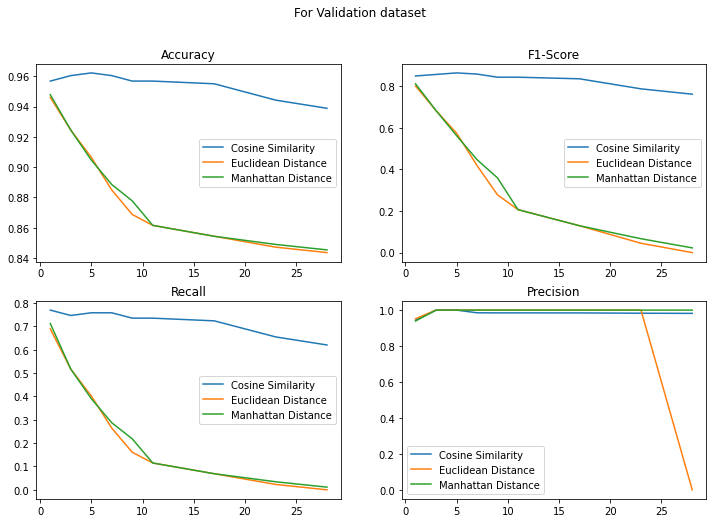

In [111]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2,2, 1)
plt.plot(cos_k_val_v,cos_acc_v)
plt.plot(ecu_k_val_v,ecu_acc_v)
plt.plot(man_k_val_v,man_acc_v)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Accuracy')

plt.subplot(2,2, 2)
plt.plot(cos_k_val_v,cos_f1_v)
plt.plot(ecu_k_val_v,ecu_f1_v)
plt.plot(man_k_val_v,man_f1_v)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('F1-Score')

plt.subplot(2,2, 3)
plt.plot(cos_k_val_v,cos_re_v)
plt.plot(ecu_k_val_v,ecu_re_v)
plt.plot(man_k_val_v,man_re_v)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Recall')

plt.subplot(2,2, 4)
plt.plot(cos_k_val_v,cos_pr_v)
plt.plot(ecu_k_val_v,ecu_pr_v)
plt.plot(man_k_val_v,man_pr_v)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Precision')

plt.suptitle("For Validation dataset")
plt.show()

##### On Test Set

In [92]:
ecu_k_val_t,ecu_predications_t,ecu_acc_t,ecu_f1_t,ecu_con_t,ecu_re_t,ecu_pr_t=try_diff_k_on_val(train_X,train_y,test_X,test_y,distance_metric=euclidean_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
man_k_val_t,man_predications_t,man_acc_t,man_f1_t,man_con_t,man_re_t,man_pr_t=try_diff_k_on_val(train_X,train_y,test_X,test_y,distance_metric=manhattan_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
cos_k_val_t,cos_predications_t,cos_acc_t,cos_f1_t,cos_con_t,cos_re_t,cos_pr_t=try_diff_k_on_val(train_X,train_y,test_X,test_y,distance_metric=cosine_similarity_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)
# ham_k_val_t,ham_predications_t,ham_acc_t,ham_f1_t,ham_con_t,ham_re_t,ham_pr_t=try_diff_k_on_val(train_X,train_y,test_X,test_y,distance_metric=hamming_distance,k=True,arr=[1,3,5,7,9,11,17,23,28],half=True)

<Figure size 432x288 with 0 Axes>

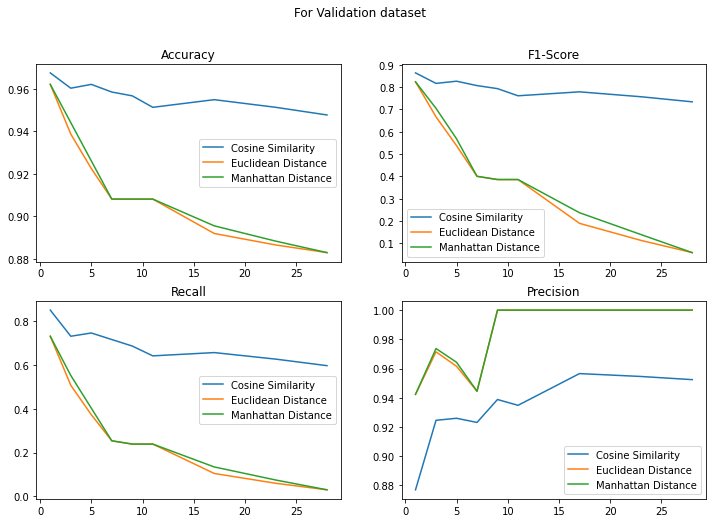

In [112]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2,2, 1)
plt.plot(cos_k_val_t,cos_acc_t)
plt.plot(ecu_k_val_t,ecu_acc_t)
plt.plot(man_k_val_t,man_acc_t)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Accuracy')

plt.subplot(2,2, 2)
plt.plot(cos_k_val_t,cos_f1_t)
plt.plot(ecu_k_val_t,ecu_f1_t)
plt.plot(man_k_val_t,man_f1_t)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('F1-Score')

plt.subplot(2,2, 3)
plt.plot(cos_k_val_t,cos_re_t)
plt.plot(ecu_k_val_t,ecu_re_t)
plt.plot(man_k_val_t,man_re_t)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Recall')

plt.subplot(2,2, 4)
plt.plot(cos_k_val_t,cos_pr_t)
plt.plot(ecu_k_val_t,ecu_pr_t)
plt.plot(man_k_val_t,man_pr_t)
plt.legend(["Cosine Similarity","Euclidean Distance","Manhattan Distance"])
plt.title('Precision')

plt.suptitle("For Test dataset")
plt.show()

#### 2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.

##### Part 1
+ By looking the graphical representation of the distance measure, we can see that the `Cosine Similarity` is the best performing distance measure as per in accuracy as well as f1-score
+ Since we don't want our ham emails to be treated as spam but can tolerate some of spam in our primary inbox so cost of `False Positvite` is high in this case hence we will conider Precision over Recall where cosine performs badly hence in this case we will use `Manhattan Distance` but will definely loose some of the accuracy.

##### Part 2
+ Euclidean Distance
    + Pros: simple  to implement and also gives better results on the spatially related data
    + Cons: invariant to scale and can attain a too large value and needs normalisation and computations increases as well when dimensions are increased (curse of dimensionality)
    + Use Case: used for low dimensionality data like 


+ Cosine Similarity
    + Cons: it already normalised to 1 and performs better than euclidean on high dimensional data
    + Pros: it ignores the magnitude of data and only considers the angle between them
    + Use Case: on high dimensional data like in case of text analysis or collaborative filtering 


+ Manhattan Distance
    + Pros: Less complexity in calculation over cosine and euclidean as dimensionality increases
    + Cons:  invariant to scale and can attain too large values even more than euclidean
    + Use Case: Dataset contains discrete values like a city block distance problem where we have to find the path between 2 points but can't take a straight line as the path.

#### 3. Report ~~Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score~~ F1-Score ,Confusion Matrix, Recall and Precision in a tabular form.

In [113]:
columns = ['k','Accuracy' ,'Confusion Matrix', 'Recall', 'Precision', 'F1-score']
arr=[]
for i in range(len(cos_k_val_t)):
    arr.append([cos_k_val_t[i],cos_acc_t[i],cos_con_t[i],cos_re_t[i],cos_pr_t[i],cos_f1_t[i]])
table_data = tabulate.tabulate(arr, columns, tablefmt='fancy_grid')
print("Cosine Similarity")
print(table_data)

Cosine Similarity
╒═════╤════════════╤════════════════════════════════════════════════════════════════════════════════════════╤══════════╤═════════════╤════════════╕
│   k │   Accuracy │ Confusion Matrix                                                                       │   Recall │   Precision │   F1-score │
╞═════╪════════════╪════════════════════════════════════════════════════════════════════════════════════════╪══════════╪═════════════╪════════════╡
│   1 │   0.967568 │ {'True Negative': 480, 'True Positive': 57, 'False Positive': 8, 'False Negative': 10} │ 0.850746 │    0.876923 │   0.863636 │
├─────┼────────────┼────────────────────────────────────────────────────────────────────────────────────────┼──────────┼─────────────┼────────────┤
│   3 │   0.96036  │ {'True Negative': 484, 'True Positive': 49, 'False Positive': 4, 'False Negative': 18} │ 0.731343 │    0.924528 │   0.816667 │
├─────┼────────────┼──────────────────────────────────────────────────────────────────────────

In [114]:
columns = ['k','Accuracy' ,'Confusion Matrix', 'Recall', 'Precision', 'F1-score']
arr=[]
for i in range(len(ecu_k_val_t)):
    arr.append([ecu_k_val_t[i],ecu_acc_t[i],ecu_con_t[i],ecu_re_t[i],ecu_pr_t[i],ecu_f1_t[i]])
table_data = tabulate.tabulate(arr, columns, tablefmt='fancy_grid')
print("Euclidean Distance")
print(table_data)

Euclidean Distance
╒═════╤════════════╤════════════════════════════════════════════════════════════════════════════════════════╤═══════════╤═════════════╤════════════╕
│   k │   Accuracy │ Confusion Matrix                                                                       │    Recall │   Precision │   F1-score │
╞═════╪════════════╪════════════════════════════════════════════════════════════════════════════════════════╪═══════════╪═════════════╪════════════╡
│   1 │   0.962162 │ {'True Negative': 485, 'True Positive': 49, 'False Positive': 3, 'False Negative': 18} │ 0.731343  │    0.942308 │   0.823529 │
├─────┼────────────┼────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────┼────────────┤
│   3 │   0.938739 │ {'True Negative': 487, 'True Positive': 34, 'False Positive': 1, 'False Negative': 33} │ 0.507463  │    0.971429 │   0.666667 │
├─────┼────────────┼───────────────────────────────────────────────────────────────────

In [115]:
columns = ['k','Accuracy' ,'Confusion Matrix', 'Recall', 'Precision', 'F1-score']
arr=[]
for i in range(len(man_k_val_t)):
    arr.append([man_k_val_t[i],man_acc_t[i],man_con_t[i],man_re_t[i],man_pr_t[i],man_f1_t[i]])
table_data = tabulate.tabulate(arr, columns, tablefmt='fancy_grid')
print("Manhattan Distance")
print(table_data)

Manhattan Distance
╒═════╤════════════╤════════════════════════════════════════════════════════════════════════════════════════╤═══════════╤═════════════╤════════════╕
│   k │   Accuracy │ Confusion Matrix                                                                       │    Recall │   Precision │   F1-score │
╞═════╪════════════╪════════════════════════════════════════════════════════════════════════════════════════╪═══════════╪═════════════╪════════════╡
│   1 │   0.962162 │ {'True Negative': 485, 'True Positive': 49, 'False Positive': 3, 'False Negative': 18} │ 0.731343  │    0.942308 │   0.823529 │
├─────┼────────────┼────────────────────────────────────────────────────────────────────────────────────────┼───────────┼─────────────┼────────────┤
│   3 │   0.944144 │ {'True Negative': 487, 'True Positive': 37, 'False Positive': 1, 'False Negative': 30} │ 0.552239  │    0.973684 │   0.704762 │
├─────┼────────────┼───────────────────────────────────────────────────────────────────

In [97]:
# # table
# columns = ['k','Accuracy' ,'Confusion Matrix', 'Recall', 'Precision', 'F1-score']
# arr=[]
# for i in range(len(ham_k_val_t)):
#     arr.append([ham_k_val_t[i],ham_acc_t[i],ham_con_t[i],ham_re_t[i],ham_pr_t[i],ham_f1_t[i]])
# table_data = tabulate.tabulate(arr, columns, tablefmt='fancy_grid')
# print("Hamming Distance")
# print(table_data)

#### 4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing ~~R2~~ F-1 score vs k.

<Figure size 432x288 with 0 Axes>

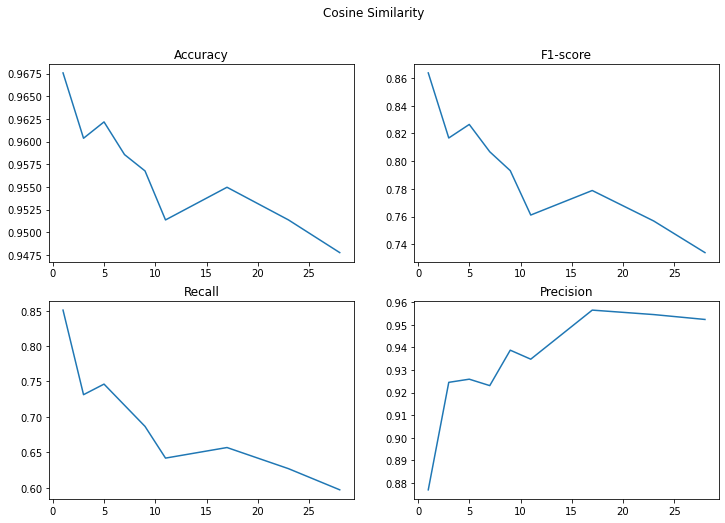

In [98]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(cos_k_val_t,cos_acc_t)
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(cos_k_val_t,cos_f1_t)
plt.title('F1-score')

plt.subplot(2, 2, 3)
plt.plot(cos_k_val_t,cos_re_t)
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(cos_k_val_t,cos_pr_t)
plt.title('Precision')

plt.suptitle("Cosine Similarity")
plt.show()

<Figure size 432x288 with 0 Axes>

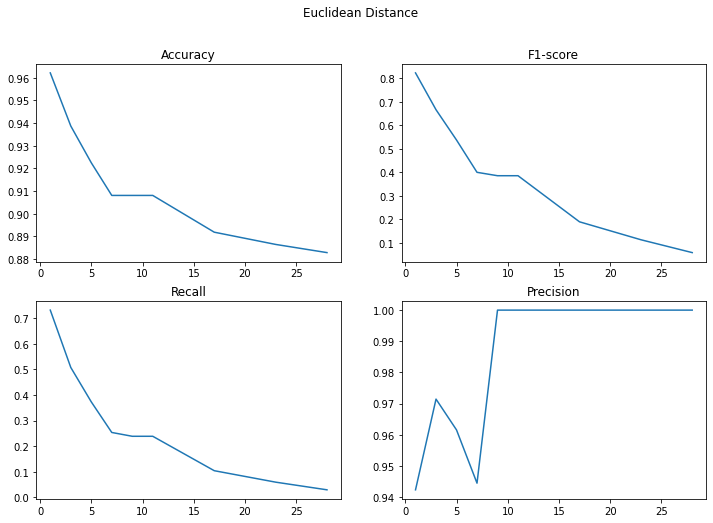

In [99]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(ecu_k_val_t,ecu_acc_t)
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(ecu_k_val_t,ecu_f1_t)
plt.title('F1-score')

plt.subplot(2, 2, 3)
plt.plot(ecu_k_val_t,ecu_re_t)
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(ecu_k_val_t,ecu_pr_t)
plt.title('Precision')

plt.suptitle("Euclidean Distance")
plt.show()

<Figure size 432x288 with 0 Axes>

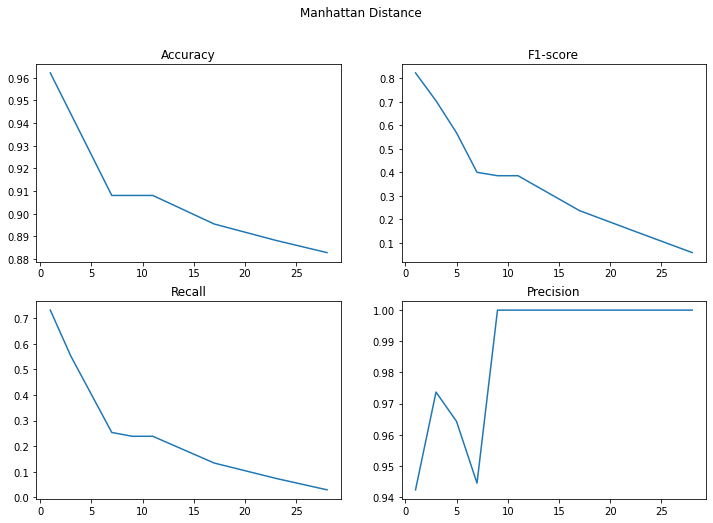

In [100]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.plot(man_k_val_t,man_acc_t)
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(man_k_val_t,man_f1_t)
plt.title('F1-score')

plt.subplot(2, 2, 3)
plt.plot(man_k_val_t,man_re_t)
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(man_k_val_t,man_pr_t)
plt.title('Precision')

plt.suptitle("Manhattan Distance")
plt.show()

##### For better understanding of the results.

<Figure size 432x288 with 0 Axes>

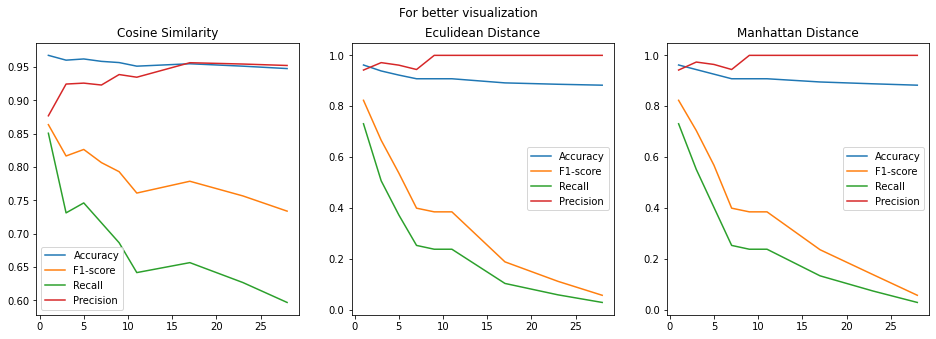

In [107]:
plt.subplots_adjust(left=1.5, bottom=1.5, right=2, top=2, wspace=1, hspace=1)
plt.figure(figsize=(16,5))
plt.subplot(1, 3, 1)
plt.plot(cos_k_val_t,cos_acc_t)
plt.plot(cos_k_val_t,cos_f1_t)
plt.plot(cos_k_val_t,cos_re_t)
plt.plot(cos_k_val_t,cos_pr_t)
plt.legend(['Accuracy','F1-score','Recall','Precision'])
plt.title('Cosine Similarity')

plt.subplot(1, 3, 2)
plt.plot(ecu_k_val_t,ecu_acc_t)
plt.plot(ecu_k_val_t,ecu_f1_t)
plt.plot(ecu_k_val_t,ecu_re_t)
plt.plot(ecu_k_val_t,ecu_pr_t)
plt.legend(['Accuracy','F1-score','Recall','Precision'])
plt.title('Eculidean Distance')

plt.subplot(1, 3, 3)
plt.plot(man_k_val_t,man_acc_t)
plt.plot(man_k_val_t,man_f1_t)
plt.plot(man_k_val_t,man_re_t)
plt.plot(man_k_val_t,man_pr_t)
plt.legend(['Accuracy','F1-score','Recall','Precision'])
plt.title('Manhattan Distance')

plt.suptitle("For better visualization")
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

##### Some Functions

In [170]:
index_dict={}
arc=0
for i in unique_words:
    index_dict[i]=arc
    arc+=1
trx_data= np.zeros([len(train_X), arc])
try_data= np.zeros([len(train_X)])
idx_dic={}
arc=0
for i in train_X.keys():
    dic=train_X[i]
    for x in dic.keys():
        trx_data[arc][index_dict[x]]=dic[x]
    try_data[arc]=train_y[i]
    idx_dic[arc]=i
    arc+=1

In [171]:
index_dict_t={}
arc=0
for i in unique_words:
    index_dict_t[i]=arc
    arc+=1
tx_data= np.zeros([len(test_X), arc])
ty_data= np.zeros([len(test_X)])

idx_dic_t={}
arc=0
for i in test_X.keys():
    dic=test_X[i]
    for x in dic.keys():
        tx_data[arc][index_dict_t[x]]=dic[x]
    ty_data[arc]=test_y[i]
    idx_dic_t[arc]=i
    arc+=1

In [172]:
k_best=1

In [173]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_jobs=-1,n_neighbors=k_best)
neigh.fit(trx_data,try_data)

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [174]:
dis,nei=neigh.kneighbors(tx_data)

In [175]:
dic_val={}
for i in range(len(nei)):
    arr=[0]*len(nei[i])
    for j in range(len(nei[i])):
        arr[j]=try_data[nei[i][j]]
    dic_val[idx_dic_t[i]]=arr

In [176]:
def predict_label_collective2(dic):
    dic_re={}
    for idx in dic:
        k_max=len(dic[idx])
        break
    
    for idx in dic:
        arr=[0]*k_max
        cur_k=0
        ctr=0
        ctr_rev=0
        for x in dic[idx]:
            if x==0:
                ctr_rev+=1
            else:
                ctr+=1
            if(ctr>ctr_rev):
                arr[cur_k]=1
            cur_k+=1
        dic_re[idx]=arr
    return dic_re

In [177]:
def my_confusion_score2(y_pred,y_true):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(y_pred)):
        if(y_pred[i]==1 and y_true[i]==1):
            TP+=1
        elif(y_pred[i]==0 and y_true[i]==0):
            TN+=1
        elif(y_pred[i]==1 and y_true[i]==0):
            FP+=1
        elif(y_pred[i]==0 and y_true[i]==1):
            FN+=1
    dic={}
    dic["True Negative"]=TN
    dic["True Positive"]=TP
    dic["False Positive"]=FP
    dic["False Negative"]=FN
    return dic

In [178]:
pp=predict_label_collective2(dic_val)
y_true=[]
y_pred=[]
arc=0
for idx in pp:
    y_pred.append(pp[idx][k_best-1])
    y_true.append(ty_data[arc])
    arc+=1

sk_knn_acc=accuracy_score(y_true,y_pred)
sk_knn_con=my_confusion_score2(y_true,y_pred)
sk_knn_f1=my_f1_score(sk_knn_con)
sk_knn_re=my_recall_score(sk_knn_con)
sk_knn_pr=my_precision_score(sk_knn_con)

##### Compare both the models result.

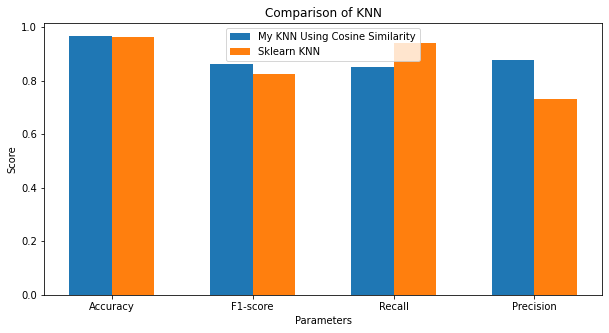

In [189]:
X = ["Accuracy","F1-score","Recall","Precision"]
knn= [sk_knn_acc,sk_knn_f1,sk_knn_re,sk_knn_pr]
my_knn_cos = [cos_acc_t[k_best-1],cos_f1_t[k_best-1],cos_re_t[k_best-1],cos_pr_t[k_best-1]]
# my_knn_ecu = [ecu_acc_t[k_best-1],ecu_f1_t[k_best-1],ecu_re_t[k_best-1],ecu_pr_t[k_best-1]]

X_axis = np.arange(len(X))
plt.figure(figsize=(10,5))

plt.bar(X_axis - 0.15, my_knn_cos, 0.3, label = 'My KNN Using Cosine Similarity')
plt.bar(X_axis + 0.15, knn, 0.3, label = 'Sklearn KNN')
# plt.bar(X_axis + 0.3, my_knn_ecu, 0.3, label = 'My KNN Using Eculidean Distance')

plt.xticks(X_axis, X)
plt.xlabel("Parameters")
plt.ylabel("Score")
plt.title("Comparison of KNN")
plt.legend()
plt.show()

+ My Best performing model is KNN with K=1 and Cosine Similarity, which has `High Accuracy`, `High F1-score`, `High Precision` but `Low Recall` compared to Sklearn's KNN model.
+  Since we don't want our ham emails to be treated as spam but can tolerate some of spam in our primary inbox so cost of `False Positvite` is high in this case hence we will conider `Precision over Recall` hence my model if better than the Sklearn KNN model.

##### What is the time complexity of training using KNN classifier?

+ The time complexity for training a KNN classifier is costant time i.e. O(1) since it doesn't perform any calculations on the data while training and no model is built.

##### What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?

+ The time complexity for testing a KNN classifier is O(N*M) where N is the size of training dataset and M is the dimension due to the all distances being calculated for a test point.
+ If we have to predict Q test points, then the time complexity is O(Q* N*M)